# Modelo Descriptivo Anual de Delitos - Santander

## 📋 Descripción

Este notebook implementa un **modelo descriptivo avanzado** para caracterizar y segmentar los municipios de Santander según sus patrones de criminalidad. A diferencia de un modelo predictivo, este enfoque busca **entender y describir** la situación actual y las tendencias históricas.

## 🎯 Objetivos

1. **Segmentación de Municipios**: Agrupar municipios con perfiles delictivos similares usando K-Means clustering
2. **Análisis de Tendencias**: Clasificar cada municipio según su tendencia temporal (Ascendente, Descendente, Estable, Volátil)
3. **Perfilado de Composición**: Identificar el delito dominante y la concentración delictiva por municipio
4. **Generación Automática de Texto (NLG)**: Crear descripciones textuales automáticas para cada municipio

## 📊 Componentes del Análisis

| Componente | Descripción | Output |
|------------|-------------|--------|
| **Clustering** | Segmentación por K-Means con selección óptima de k | Grupos de municipios similares |
| **Tendencias** | Regresión lineal temporal por municipio | Clasificación de tendencia |
| **Composición** | Proporciones de tipos de delitos | Delito dominante, índice de concentración |
| **Descripciones** | Plantillas + datos = texto descriptivo | Perfiles textuales automáticos |

## 📁 Outputs Generados

- `perfiles_municipios_{timestamp}.json` - Perfil completo por municipio
- `perfiles_clusters_{timestamp}.json` - Características de cada cluster
- `descriptive_metadata_{timestamp}.json` - Metadata del modelo
- `municipios_perfilados_{timestamp}.parquet` - Dataset final enriquecido

## 🔧 Uso Principal

Los outputs están diseñados para:
- **Chatbots**: Responder preguntas sobre municipios específicos
- **Dashboards**: Visualización de perfiles y clusters
- **Reportes**: Generación automática de informes descriptivos

---

In [1]:
# =============================================================================
# CONFIGURACION E IMPORTACIONES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
import json
from datetime import datetime

# Sklearn - Clustering y Preprocesamiento
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

# Configuracion de visualizacion
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
pd.set_option('display.max_columns', 50)

# Rutas
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / 'data' / 'gold' / 'model' / 'regression_annual_dataset.parquet'
OUTPUT_DIR = BASE_DIR / 'models' / 'descriptivo' / 'annual'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Dataset:", DATA_PATH)
print("Output:", OUTPUT_DIR)

Dataset: /Users/byverbel/quick_projects/Datos-al-Ecosistema/data/gold/model/regression_annual_dataset.parquet
Output: /Users/byverbel/quick_projects/Datos-al-Ecosistema/models/descriptivo/annual


---
## 1. Carga y Preparacion de Datos

In [2]:
# 1.1 Cargar datos
df = pd.read_parquet(DATA_PATH)

print("=" * 70)
print("INFORMACION GENERAL DEL DATASET")
print("=" * 70)
print(f"\n> Shape: {df.shape[0]:,} registros x {df.shape[1]} columnas")
print(f"> Periodo: {df['anio'].min()} - {df['anio'].max()}")
print(f"> Municipios: {df['codigo_municipio'].nunique()}")

# Definir columnas por categoria
DELITOS_COLS = ['ABIGEATO', 'HURTOS', 'LESIONES', 'VIOLENCIA INTRAFAMILIAR', 
                'AMENAZAS', 'DELITOS SEXUALES', 'EXTORSION', 'HOMICIDIOS']

DEMO_COLS = ['poblacion_total', 'poblacion_menores', 'poblacion_adultos', 
             'poblacion_adolescentes', 'area_km2', 'densidad_poblacional', 'centros_por_km2']

TASA_COLS = [c for c in df.columns if c.startswith('tasa_')]

print(f"\n> Columnas de delitos: {len(DELITOS_COLS)}")
print(f"> Columnas demograficas: {len(DEMO_COLS)}")
print(f"> Columnas de tasas: {len(TASA_COLS)}")

df.head()

INFORMACION GENERAL DEL DATASET

> Shape: 1,388 registros x 26 columnas
> Periodo: 2010 - 2025
> Municipios: 87

> Columnas de delitos: 8
> Columnas demograficas: 7
> Columnas de tasas: 8


,codigo_municipio,anio,poblacion_total,poblacion_menores,poblacion_adultos,poblacion_adolescentes,area_km2,densidad_poblacional,centros_por_km2,total_delitos,ABIGEATO,HURTOS,LESIONES,VIOLENCIA INTRAFAMILIAR,AMENAZAS,DELITOS SEXUALES,EXTORSION,HOMICIDIOS,tasa_abigeato,tasa_hurtos,tasa_lesiones,tasa_violencia intrafamiliar,tasa_amenazas,tasa_delitos sexuales,tasa_extorsion,tasa_homicidios
0,68001,2010,1048060.0,122333.0,879556.0,46171.0,152.915686,6853.842316,0.00654,8822.0,2.0,2811.0,3814.0,1002.0,360.0,638.0,27.0,168.0,0.190829,268.209835,363.910463,95.605213,34.349178,60.874377,2.576188,16.029617
1,68001,2011,1050238.0,120475.0,884052.0,45711.0,152.915686,6868.085459,0.00654,10095.0,0.0,3032.0,4590.0,1529.0,378.0,389.0,17.0,160.0,0.000000,288.696467,437.043794,145.586048,35.991842,37.039223,1.618681,15.234642
2,68001,2012,1052112.0,118590.0,888231.0,45291.0,152.915686,6880.340579,0.00654,10793.0,0.0,3417.0,4750.0,1530.0,441.0,462.0,36.0,157.0,0.000000,324.775309,451.472847,145.421780,41.915690,43.911675,3.421689,14.922366
3,68001,2013,1053654.0,116697.0,892060.0,44897.0,152.915686,6890.424567,0.00654,10593.0,0.0,3353.0,4641.0,1443.0,510.0,435.0,45.0,166.0,0.000000,318.225907,440.467174,136.951979,48.402986,41.284900,4.270852,15.754697
4,68001,2014,1054902.0,114813.0,895621.0,44468.0,152.915686,6898.585927,0.00654,10438.0,2.0,3032.0,4175.0,1879.0,499.0,656.0,53.0,142.0,0.189591,287.420064,395.771361,178.120811,47.302972,62.185871,5.024163,13.460966


In [3]:
# 1.2 Crear dataset agregado por municipio (promedio historico)
print("=" * 70)
print("CREANDO DATASET AGREGADO POR MUNICIPIO")
print("=" * 70)

# Agregaciones por municipio
agg_dict = {
    'total_delitos': ['mean', 'std', 'min', 'max', 'sum'],
    'poblacion_total': 'mean',
    'densidad_poblacional': 'mean',
    'area_km2': 'first',
    'anio': ['min', 'max', 'count']
}

# Agregar columnas de delitos
for col in DELITOS_COLS:
    agg_dict[col] = ['mean', 'sum']

# Agregar tasas
for col in TASA_COLS:
    agg_dict[col] = 'mean'

df_municipio = df.groupby('codigo_municipio').agg(agg_dict)
df_municipio.columns = ['_'.join(col).strip() for col in df_municipio.columns.values]
df_municipio = df_municipio.reset_index()

# Renombrar columnas para claridad
df_municipio = df_municipio.rename(columns={
    'total_delitos_mean': 'delitos_promedio',
    'total_delitos_std': 'delitos_variabilidad',
    'total_delitos_sum': 'delitos_total',
    'poblacion_total_mean': 'poblacion',
    'densidad_poblacional_mean': 'densidad',
    'area_km2_first': 'area_km2',
    'anio_count': 'anios_datos'
})

print(f"\n> Dataset agregado: {df_municipio.shape}")
print(f"> Columnas: {df_municipio.columns.tolist()[:15]}...")

df_municipio.head()

CREANDO DATASET AGREGADO POR MUNICIPIO

> Dataset agregado: (87, 36)
> Columnas: ['codigo_municipio', 'delitos_promedio', 'delitos_variabilidad', 'total_delitos_min', 'total_delitos_max', 'delitos_total', 'poblacion', 'densidad', 'area_km2', 'anio_min', 'anio_max', 'anios_datos', 'ABIGEATO_mean', 'ABIGEATO_sum', 'HURTOS_mean']...


,codigo_municipio,delitos_promedio,delitos_variabilidad,total_delitos_min,total_delitos_max,delitos_total,poblacion,densidad,area_km2,anio_min,anio_max,anios_datos,ABIGEATO_mean,ABIGEATO_sum,HURTOS_mean,HURTOS_sum,LESIONES_mean,LESIONES_sum,VIOLENCIA INTRAFAMILIAR_mean,VIOLENCIA INTRAFAMILIAR_sum,AMENAZAS_mean,AMENAZAS_sum,DELITOS SEXUALES_mean,DELITOS SEXUALES_sum,EXTORSION_mean,EXTORSION_sum,HOMICIDIOS_mean,HOMICIDIOS_sum,tasa_abigeato_mean,tasa_hurtos_mean,tasa_lesiones_mean,tasa_violencia intrafamiliar_mean,tasa_amenazas_mean,tasa_delitos sexuales_mean,tasa_extorsion_mean,tasa_homicidios_mean
0,68001,12340.6875,2355.777090,8822.0,17940.0,197451.0,829888.6250,5427.099379,152.915686,2010,2025,16,0.8750,14.0,5422.8750,86766.0,3737.6250,59802.0,1823.0000,29168.0,685.7500,10972.0,440.5625,7049.0,57.2500,916.0,172.7500,2764.0,0.119104,768.239938,465.755973,245.009629,96.135322,55.733089,8.134415,23.116066
1,68013,7.8750,3.461695,1.0,14.0,126.0,2845.4375,37.822548,75.231248,2010,2025,16,0.0625,1.0,0.5000,8.0,3.0000,48.0,1.4375,23.0,1.6250,26.0,1.1250,18.0,0.0625,1.0,0.0625,1.0,1.736111,21.414300,111.643503,60.365164,60.960048,57.580300,3.192033,3.248441
2,68020,18.0000,9.528903,5.0,43.0,288.0,7118.6250,42.827307,166.216966,2010,2025,16,0.6250,10.0,2.8125,45.0,4.2500,68.0,4.0625,65.0,3.2500,52.0,1.9375,31.0,0.2500,4.0,0.8125,13.0,12.168560,50.128293,77.156177,74.608474,55.333212,29.061306,3.287757,14.064780
3,68051,69.8125,16.412267,51.0,112.0,1117.0,12594.3125,74.175142,169.791552,2010,2025,16,0.3125,5.0,8.3125,133.0,39.9375,639.0,8.8750,142.0,4.8125,77.0,4.1250,66.0,0.1875,3.0,3.2500,52.0,3.623632,75.012740,345.661070,83.049997,46.082035,41.256880,1.126315,30.361995
4,68077,592.9375,166.565490,424.0,1026.0,9487.0,44460.4375,952.759995,46.664887,2010,2025,16,1.8125,29.0,143.6250,2298.0,260.4375,4167.0,92.3125,1477.0,56.3750,902.0,25.0000,400.0,3.1875,51.0,10.1875,163.0,4.449232,347.055570,648.066926,249.098253,150.552346,59.891825,8.382590,24.794017


---
## 2. Analisis de Tendencias Temporales

In [4]:
# 2.1 Calcular tendencia por municipio (regresion lineal)
print("=" * 70)
print("CALCULO DE TENDENCIAS TEMPORALES")
print("=" * 70)

def calcular_tendencia(grupo):
    """Calcula la pendiente de tendencia y metricas asociadas."""
    if len(grupo) < 3:
        return pd.Series({
            'pendiente': np.nan,
            'r_squared': np.nan,
            'cambio_porcentual': np.nan,
            'volatilidad': np.nan
        })
    
    x = grupo['anio'].values
    y = grupo['total_delitos'].values
    
    # Regresion lineal
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Cambio porcentual total
    primer_valor = y[0] if y[0] > 0 else 1
    cambio_pct = ((y[-1] - y[0]) / primer_valor) * 100
    
    # Volatilidad (coeficiente de variacion)
    volatilidad = (np.std(y) / np.mean(y)) * 100 if np.mean(y) > 0 else 0
    
    return pd.Series({
        'pendiente': slope,
        'r_squared': r_value ** 2,
        'cambio_porcentual': cambio_pct,
        'volatilidad': volatilidad
    })

# Calcular tendencias
df_tendencias = df.groupby('codigo_municipio').apply(calcular_tendencia).reset_index()

print(f"\n> Tendencias calculadas para {len(df_tendencias)} municipios")
print(f"\n> Estadisticas de pendientes:")
print(df_tendencias['pendiente'].describe())

CALCULO DE TENDENCIAS TEMPORALES

> Tendencias calculadas para 87 municipios

> Estadisticas de pendientes:
count     87.000000
mean       9.674452
std       42.803455
min       -8.629412
25%       -0.057353
50%        0.342647
75%        1.430147
max      339.669118
Name: pendiente, dtype: float64


CLASIFICACION DE TENDENCIAS

> Distribucion de tendencias:
clasificacion
Estable        56
Volatil        16
Ascendente     13
Descendente     2
Name: count, dtype: int64


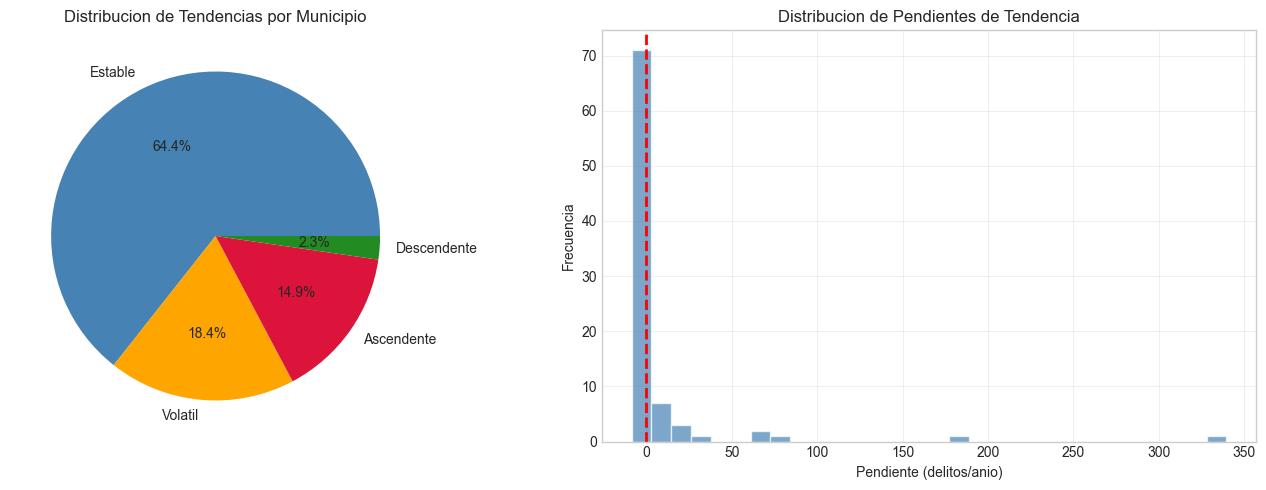

In [5]:
# 2.2 Clasificar tendencias
print("=" * 70)
print("CLASIFICACION DE TENDENCIAS")
print("=" * 70)

def clasificar_tendencia(row):
    """Clasifica la tendencia basado en pendiente, R2 y volatilidad."""
    pendiente = row['pendiente']
    r2 = row['r_squared']
    volatilidad = row['volatilidad']
    
    if pd.isna(pendiente):
        return 'Sin datos'
    
    # Umbrales
    umbral_pendiente = 2  # delitos por anio
    umbral_r2 = 0.3  # ajuste minimo para considerar tendencia clara
    umbral_volatilidad = 50  # % de coeficiente de variacion
    
    # Clasificacion
    if volatilidad > umbral_volatilidad and r2 < umbral_r2:
        return 'Volatil'
    elif pendiente > umbral_pendiente and r2 >= umbral_r2:
        return 'Ascendente'
    elif pendiente < -umbral_pendiente and r2 >= umbral_r2:
        return 'Descendente'
    else:
        return 'Estable'

df_tendencias['clasificacion'] = df_tendencias.apply(clasificar_tendencia, axis=1)

# Conteo de clasificaciones
print("\n> Distribucion de tendencias:")
print(df_tendencias['clasificacion'].value_counts())

# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
clasificacion_counts = df_tendencias['clasificacion'].value_counts()
colors = {'Ascendente': 'crimson', 'Descendente': 'forestgreen', 'Estable': 'steelblue', 'Volatil': 'orange', 'Sin datos': 'gray'}
axes[0].pie(clasificacion_counts.values, labels=clasificacion_counts.index, autopct='%1.1f%%',
            colors=[colors.get(c, 'gray') for c in clasificacion_counts.index])
axes[0].set_title('Distribucion de Tendencias por Municipio')

# Histograma de pendientes
axes[1].hist(df_tendencias['pendiente'].dropna(), bins=30, color='steelblue', edgecolor='white', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Pendiente (delitos/anio)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribucion de Pendientes de Tendencia')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# 2.3 Municipios con tendencias mas preocupantes
print("=" * 70)
print("MUNICIPIOS CON TENDENCIAS PREOCUPANTES")
print("=" * 70)

# Top municipios con tendencia ascendente
ascendentes = df_tendencias[df_tendencias['clasificacion'] == 'Ascendente'].nlargest(10, 'pendiente')
print("\n> Top 10 municipios con mayor crecimiento de delitos:")
print(ascendentes[['codigo_municipio', 'pendiente', 'cambio_porcentual', 'r_squared']].to_string(index=False))

# Top municipios con mejora
descendentes = df_tendencias[df_tendencias['clasificacion'] == 'Descendente'].nsmallest(10, 'pendiente')
print("\n> Top 10 municipios con mayor reduccion de delitos:")
print(descendentes[['codigo_municipio', 'pendiente', 'cambio_porcentual', 'r_squared']].to_string(index=False))

MUNICIPIOS CON TENDENCIAS PREOCUPANTES

> Top 10 municipios con mayor crecimiento de delitos:
 codigo_municipio  pendiente  cambio_porcentual  r_squared
            68001 339.669118          71.174337   0.471228
            68081 179.263235          92.181891   0.371848
            68307  82.405882          88.588589   0.362012
            68547  71.569118         125.060048   0.353435
            68575  27.686765         262.400000   0.634733
            68406  16.420588         104.605263   0.452405
            68655  15.232353          57.485030   0.459062
            68573   9.019118         660.000000   0.626287
            68235   4.444118         225.806452   0.748280
            68418   4.175000          52.307692   0.369778

> Top 10 municipios con mayor reduccion de delitos:
 codigo_municipio  pendiente  cambio_porcentual  r_squared
            68572  -4.950000         -16.666667   0.365164
            68167  -2.948529         -13.274336   0.310072


---
## 3. Perfilado de Composicion Delictiva

In [7]:
# 3.1 Calcular proporcion de cada tipo de delito por municipio
print("=" * 70)
print("COMPOSICION DELICTIVA POR MUNICIPIO")
print("=" * 70)

# Sumar delitos por tipo y municipio
df_composicion = df.groupby('codigo_municipio')[DELITOS_COLS].sum()

# Calcular total por municipio
df_composicion['total'] = df_composicion.sum(axis=1)

# Calcular proporciones
for col in DELITOS_COLS:
    df_composicion[f'prop_{col}'] = (df_composicion[col] / df_composicion['total'] * 100).round(2)

# Determinar delito dominante
prop_cols = [f'prop_{col}' for col in DELITOS_COLS]
df_composicion['delito_dominante'] = df_composicion[prop_cols].idxmax(axis=1).str.replace('prop_', '')
df_composicion['prop_dominante'] = df_composicion[prop_cols].max(axis=1)

# Calcular indice de concentracion (Herfindahl)
df_composicion['indice_concentracion'] = df_composicion[prop_cols].apply(
    lambda x: ((x/100)**2).sum(), axis=1
)

df_composicion = df_composicion.reset_index()

print(f"\n> Composicion calculada para {len(df_composicion)} municipios")
print(f"\n> Delito dominante mas frecuente:")
print(df_composicion['delito_dominante'].value_counts())

COMPOSICION DELICTIVA POR MUNICIPIO

> Composicion calculada para 87 municipios

> Delito dominante mas frecuente:
delito_dominante
LESIONES                   77
VIOLENCIA INTRAFAMILIAR     8
HURTOS                      2
Name: count, dtype: int64


VISUALIZACION DE COMPOSICION DELICTIVA

> Composicion general de delitos en Santander:
  - HURTOS: 33.91%
  - LESIONES: 32.99%
  - VIOLENCIA INTRAFAMILIAR: 17.63%
  - AMENAZAS: 7.83%
  - DELITOS SEXUALES: 4.84%
  - HOMICIDIOS: 1.99%
  - EXTORSION: 0.54%
  - ABIGEATO: 0.27%


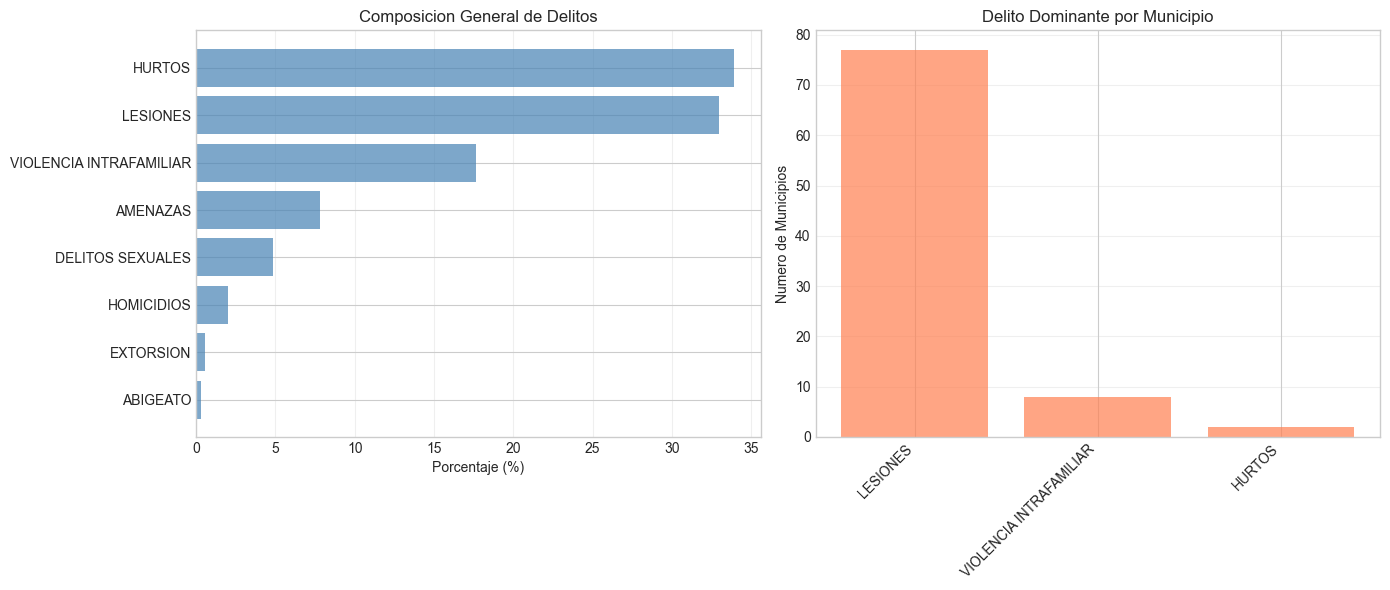

In [8]:
# 3.2 Visualizacion de composicion delictiva
print("=" * 70)
print("VISUALIZACION DE COMPOSICION DELICTIVA")
print("=" * 70)

# Composicion promedio general
composicion_general = df[DELITOS_COLS].sum()
composicion_pct = (composicion_general / composicion_general.sum() * 100).round(2)

print("\n> Composicion general de delitos en Santander:")
for delito, pct in composicion_pct.sort_values(ascending=False).items():
    print(f"  - {delito}: {pct}%")

# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Barras horizontales
y_pos = range(len(composicion_pct))
sorted_pct = composicion_pct.sort_values(ascending=True)
axes[0].barh(y_pos, sorted_pct.values, color='steelblue', alpha=0.7)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(sorted_pct.index)
axes[0].set_xlabel('Porcentaje (%)')
axes[0].set_title('Composicion General de Delitos')
axes[0].grid(True, alpha=0.3, axis='x')

# Distribucion de delito dominante
dominante_counts = df_composicion['delito_dominante'].value_counts()
axes[1].bar(range(len(dominante_counts)), dominante_counts.values, color='coral', alpha=0.7)
axes[1].set_xticks(range(len(dominante_counts)))
axes[1].set_xticklabels(dominante_counts.index, rotation=45, ha='right')
axes[1].set_ylabel('Numero de Municipios')
axes[1].set_title('Delito Dominante por Municipio')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## 4. Segmentacion de Municipios (Clustering)

In [9]:
# 4.1 Preparar datos para clustering
print("=" * 70)
print("PREPARACION DE DATOS PARA CLUSTERING")
print("=" * 70)

# Unir todos los datasets
df_cluster = df_municipio[['codigo_municipio', 'delitos_promedio', 'delitos_variabilidad', 
                           'poblacion', 'densidad', 'area_km2']].copy()

# Agregar tendencias
df_cluster = df_cluster.merge(df_tendencias[['codigo_municipio', 'pendiente', 'volatilidad']], 
                               on='codigo_municipio', how='left')

# Agregar composicion
prop_cols = [f'prop_{col}' for col in DELITOS_COLS]
df_cluster = df_cluster.merge(df_composicion[['codigo_municipio'] + prop_cols + ['indice_concentracion']], 
                               on='codigo_municipio', how='left')

# Eliminar nulos
df_cluster = df_cluster.dropna()

# Seleccionar features para clustering
feature_cols_cluster = ['delitos_promedio', 'delitos_variabilidad', 'poblacion', 'densidad', 
                        'pendiente', 'volatilidad', 'indice_concentracion'] + prop_cols

X_cluster = df_cluster[feature_cols_cluster].copy()

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(f"\n> Municipios para clustering: {len(df_cluster)}")
print(f"> Features utilizadas: {len(feature_cols_cluster)}")
print(f"> Features: {feature_cols_cluster}")

PREPARACION DE DATOS PARA CLUSTERING

> Municipios para clustering: 87
> Features utilizadas: 15
> Features: ['delitos_promedio', 'delitos_variabilidad', 'poblacion', 'densidad', 'pendiente', 'volatilidad', 'indice_concentracion', 'prop_ABIGEATO', 'prop_HURTOS', 'prop_LESIONES', 'prop_VIOLENCIA INTRAFAMILIAR', 'prop_AMENAZAS', 'prop_DELITOS SEXUALES', 'prop_EXTORSION', 'prop_HOMICIDIOS']


SELECCION DE NUMERO OPTIMO DE CLUSTERS

> Mejor k por silueta: 2 (score: 0.6253)


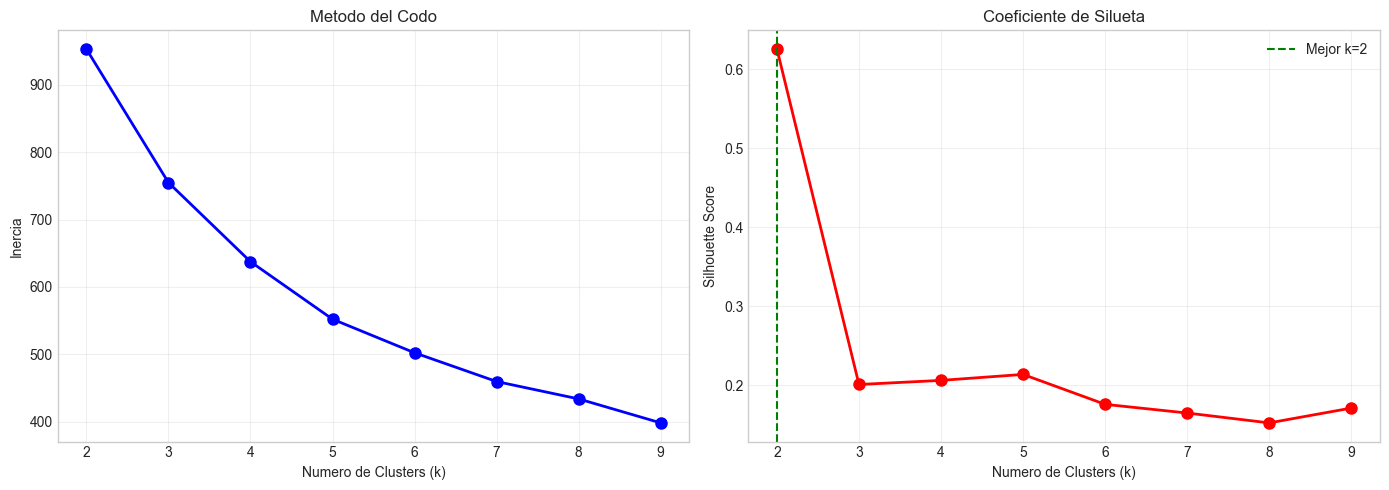

In [10]:
# 4.2 Determinar numero optimo de clusters
print("=" * 70)
print("SELECCION DE NUMERO OPTIMO DE CLUSTERS")
print("=" * 70)

# Evaluar diferentes valores de k
k_range = range(2, 10)
inertias = []
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# Mejor k por silueta
mejor_k = k_range[np.argmax(silhouettes)]
print(f"\n> Mejor k por silueta: {mejor_k} (score: {max(silhouettes):.4f})")

# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metodo del codo
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Numero de Clusters (k)')
axes[0].set_ylabel('Inercia')
axes[0].set_title('Metodo del Codo')
axes[0].grid(True, alpha=0.3)

# Silueta
axes[1].plot(k_range, silhouettes, 'ro-', linewidth=2, markersize=8)
axes[1].axvline(x=mejor_k, color='green', linestyle='--', label=f'Mejor k={mejor_k}')
axes[1].set_xlabel('Numero de Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Coeficiente de Silueta')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# 4.3 Aplicar K-Means con k optimo
print("=" * 70)
print("APLICANDO CLUSTERING")
print("=" * 70)

# Usar k=4 o el optimo (minimo 3 para tener grupos significativos)
n_clusters = max(mejor_k, 3)
print(f"\n> Usando k = {n_clusters} clusters")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Silueta final
sil_score = silhouette_score(X_scaled, df_cluster['cluster'])
print(f"> Silhouette Score: {sil_score:.4f}")

# Distribucion de clusters
print(f"\n> Distribucion de municipios por cluster:")
print(df_cluster['cluster'].value_counts().sort_index())

APLICANDO CLUSTERING

> Usando k = 3 clusters
> Silhouette Score: 0.2009

> Distribucion de municipios por cluster:
cluster
0    41
1    43
2     3
Name: count, dtype: int64


In [12]:
# 4.4 Perfilar y nombrar clusters
print("=" * 70)
print("PERFILADO DE CLUSTERS")
print("=" * 70)

# Estadisticas por cluster
perfil_clusters = df_cluster.groupby('cluster')[feature_cols_cluster].mean()

# Funcion para nombrar clusters basado en caracteristicas
def nombrar_cluster(row, perfil_general):
    """Genera nombre descriptivo para el cluster."""
    nombres = []
    
    # Nivel de delitos
    if row['delitos_promedio'] > perfil_general['delitos_promedio'] * 1.5:
        nombres.append('Alto Riesgo')
    elif row['delitos_promedio'] < perfil_general['delitos_promedio'] * 0.5:
        nombres.append('Bajo Riesgo')
    else:
        nombres.append('Riesgo Medio')
    
    # Tendencia
    if row['pendiente'] > 5:
        nombres.append('Creciente')
    elif row['pendiente'] < -5:
        nombres.append('Decreciente')
    
    # Densidad
    if row['densidad'] > perfil_general['densidad'] * 2:
        nombres.append('Urbano')
    elif row['densidad'] < perfil_general['densidad'] * 0.3:
        nombres.append('Rural')
    
    return ' - '.join(nombres) if nombres else 'General'

# Perfil general
perfil_general = df_cluster[feature_cols_cluster].mean()

# Generar nombres
nombres_clusters = {}
for cluster_id in range(n_clusters):
    perfil = perfil_clusters.loc[cluster_id]
    nombre = nombrar_cluster(perfil, perfil_general)
    nombres_clusters[cluster_id] = nombre
    print(f"\n> Cluster {cluster_id}: {nombre}")
    print(f"  - Delitos promedio: {perfil['delitos_promedio']:.1f}")
    print(f"  - Pendiente: {perfil['pendiente']:.2f}")
    print(f"  - Densidad: {perfil['densidad']:.1f}")
    print(f"  - Poblacion: {perfil['poblacion']:.0f}")

# Agregar nombre al dataframe
df_cluster['cluster_nombre'] = df_cluster['cluster'].map(nombres_clusters)

PERFILADO DE CLUSTERS

> Cluster 0: Bajo Riesgo - Rural
  - Delitos promedio: 31.4
  - Pendiente: 1.37
  - Densidad: 37.6
  - Poblacion: 8250

> Cluster 1: Riesgo Medio
  - Delitos promedio: 242.5
  - Pendiente: 4.66
  - Densidad: 134.9
  - Poblacion: 30448

> Cluster 2: Alto Riesgo - Creciente - Urbano
  - Delitos promedio: 6683.5
  - Pendiente: 195.06
  - Densidad: 3298.8
  - Poblacion: 517758


VISUALIZACION DE CLUSTERS

> Varianza explicada por PCA: 59.1%
  - PC1: 39.5%
  - PC2: 19.6%


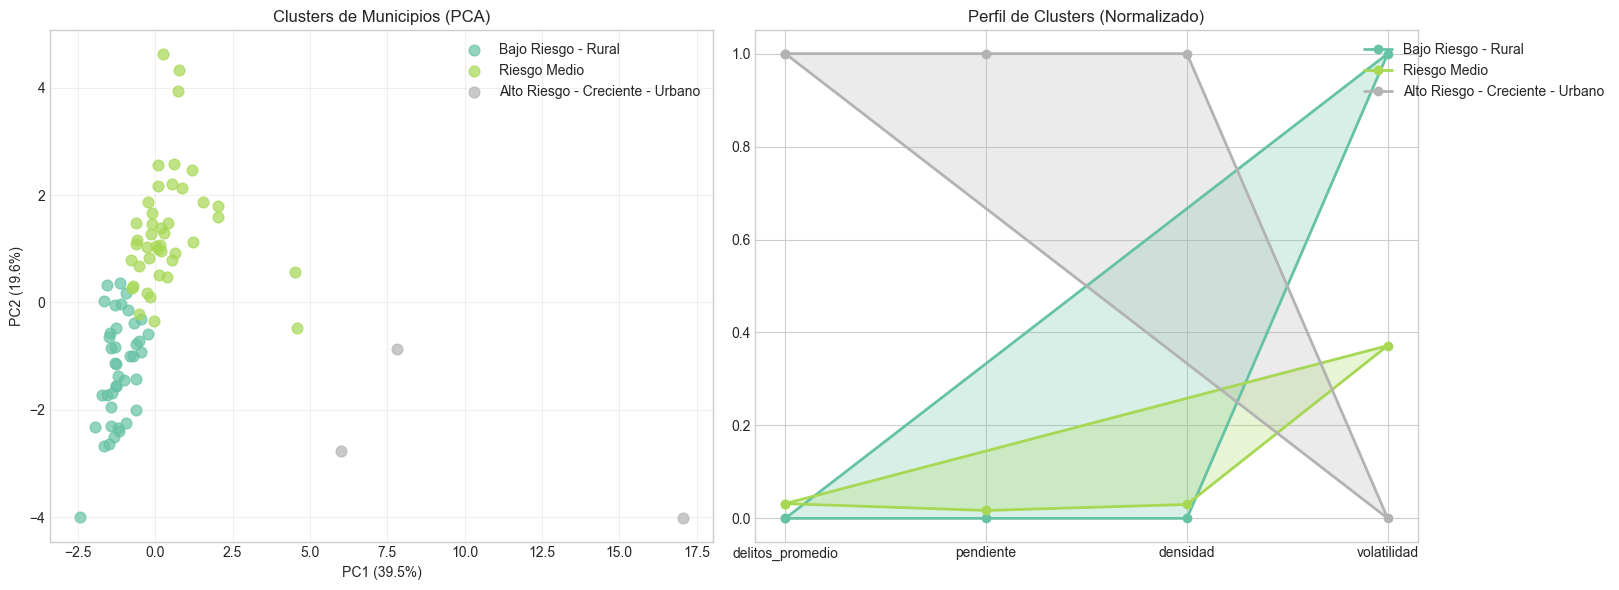

In [13]:
# 4.5 Visualizacion de clusters con PCA
print("=" * 70)
print("VISUALIZACION DE CLUSTERS")
print("=" * 70)

# Reducir a 2D con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"\n> Varianza explicada por PCA: {pca.explained_variance_ratio_.sum()*100:.1f}%")
print(f"  - PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"  - PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")

# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter PCA
colors = plt.cm.Set2(np.linspace(0, 1, n_clusters))
for i in range(n_clusters):
    mask = df_cluster['cluster'] == i
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                    c=[colors[i]], label=nombres_clusters[i], s=60, alpha=0.7)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('Clusters de Municipios (PCA)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Radar chart de perfiles
# Seleccionar variables clave para radar
radar_cols = ['delitos_promedio', 'pendiente', 'densidad', 'volatilidad']
radar_data = perfil_clusters[radar_cols].copy()

# Normalizar para radar
radar_normalized = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())

# Crear radar
angles = np.linspace(0, 2*np.pi, len(radar_cols), endpoint=False).tolist()
angles += angles[:1]  # Cerrar el circulo

for i in range(n_clusters):
    values = radar_normalized.loc[i].values.tolist()
    values += values[:1]
    axes[1].plot(angles, values, 'o-', linewidth=2, label=nombres_clusters[i], color=colors[i])
    axes[1].fill(angles, values, alpha=0.25, color=colors[i])

axes[1].set_xticks(angles[:-1])
axes[1].set_xticklabels(radar_cols)
axes[1].set_title('Perfil de Clusters (Normalizado)')
axes[1].legend(loc='upper right', bbox_to_anchor=(1.3, 1))

plt.tight_layout()
plt.show()

---
## 5. Generacion de Perfiles Descriptivos

In [14]:
# 5.1 Crear dataset final con toda la informacion
print("=" * 70)
print("CREANDO DATASET DESCRIPTIVO FINAL")
print("=" * 70)

# Unir toda la informacion
df_final = df_cluster[['codigo_municipio', 'delitos_promedio', 'poblacion', 'densidad', 'cluster', 'cluster_nombre']].copy()

# Agregar tendencia
df_final = df_final.merge(df_tendencias[['codigo_municipio', 'pendiente', 'cambio_porcentual', 'clasificacion']], 
                          on='codigo_municipio', how='left')
df_final = df_final.rename(columns={'clasificacion': 'tendencia'})

# Agregar composicion
df_final = df_final.merge(df_composicion[['codigo_municipio', 'delito_dominante', 'prop_dominante']], 
                          on='codigo_municipio', how='left')

print(f"\n> Dataset final: {df_final.shape}")
print(f"\n> Columnas: {df_final.columns.tolist()}")

df_final.head(10)

CREANDO DATASET DESCRIPTIVO FINAL

> Dataset final: (87, 11)

> Columnas: ['codigo_municipio', 'delitos_promedio', 'poblacion', 'densidad', 'cluster', 'cluster_nombre', 'pendiente', 'cambio_porcentual', 'tendencia', 'delito_dominante', 'prop_dominante']


,codigo_municipio,delitos_promedio,poblacion,densidad,cluster,cluster_nombre,pendiente,cambio_porcentual,tendencia,delito_dominante,prop_dominante
0,68001,12340.6875,829888.6250,5427.099379,2,Alto Riesgo - Creciente - Urbano,339.669118,71.174337,Ascendente,HURTOS,43.94
1,68013,7.8750,2845.4375,37.822548,0,Bajo Riesgo - Rural,0.261765,1300.000000,Estable,LESIONES,38.10
2,68020,18.0000,7118.6250,42.827307,0,Bajo Riesgo - Rural,0.370588,123.076923,Volatil,LESIONES,23.61
3,68051,69.8125,12594.3125,74.175142,1,Riesgo Medio,0.630882,75.000000,Estable,LESIONES,57.21
4,68077,592.9375,44460.4375,952.759995,1,Riesgo Medio,15.936765,108.314088,Estable,LESIONES,43.92
5,68079,48.3125,12740.1875,92.807228,1,Riesgo Medio,2.283824,64.150943,Estable,LESIONES,34.54
6,68081,4184.5625,297491.1875,224.210582,2,Alto Riesgo - Creciente - Urbano,179.263235,92.181891,Ascendente,LESIONES,28.05
7,68092,47.2500,8216.9375,19.053825,1,Riesgo Medio,-0.700000,34.883721,Estable,LESIONES,41.53
8,68101,54.1250,18397.0000,18.212582,0,Bajo Riesgo - Rural,0.032353,102.702703,Estable,LESIONES,38.22
9,68121,10.3750,3210.9375,48.966394,0,Bajo Riesgo - Rural,0.144118,-33.333333,Estable,VIOLENCIA INTRAFAMILIAR,40.36


In [15]:
# 5.2 Generar descripciones automaticas
print("=" * 70)
print("GENERANDO DESCRIPCIONES AUTOMATICAS")
print("=" * 70)

def generar_descripcion(row):
    """Genera descripcion textual para un municipio."""
    
    # Nivel de riesgo
    if row['delitos_promedio'] > 500:
        nivel = 'alto'
    elif row['delitos_promedio'] > 100:
        nivel = 'medio'
    else:
        nivel = 'bajo'
    
    # Tendencia texto
    tendencia_texto = {
        'Ascendente': f"con tendencia ASCENDENTE (+{row['cambio_porcentual']:.1f}% en el periodo)",
        'Descendente': f"con tendencia DESCENDENTE ({row['cambio_porcentual']:.1f}% en el periodo)",
        'Estable': "con tendencia ESTABLE",
        'Volatil': "con comportamiento VOLATIL"
    }.get(row['tendencia'], '')
    
    descripcion = f"""El municipio {int(row['codigo_municipio'])} pertenece al grupo '{row['cluster_nombre']}'. 
Presenta un nivel de criminalidad {nivel} con un promedio de {row['delitos_promedio']:.0f} delitos anuales, {tendencia_texto}. 
El delito predominante es {row['delito_dominante']} ({row['prop_dominante']:.1f}% del total). 
Poblacion: {row['poblacion']:,.0f} habitantes. Densidad: {row['densidad']:.1f} hab/km2."""
    
    return descripcion.replace('\n', ' ').strip()

# Generar descripciones
df_final['descripcion'] = df_final.apply(generar_descripcion, axis=1)

# Mostrar ejemplos
print("\n> Ejemplos de descripciones generadas:")
for i, row in df_final.head(3).iterrows():
    print(f"\n[Municipio {int(row['codigo_municipio'])}]")
    print(row['descripcion'])

GENERANDO DESCRIPCIONES AUTOMATICAS

> Ejemplos de descripciones generadas:

[Municipio 68001]
El municipio 68001 pertenece al grupo 'Alto Riesgo - Creciente - Urbano'.  Presenta un nivel de criminalidad alto con un promedio de 12341 delitos anuales, con tendencia ASCENDENTE (+71.2% en el periodo).  El delito predominante es HURTOS (43.9% del total).  Poblacion: 829,889 habitantes. Densidad: 5427.1 hab/km2.

[Municipio 68013]
El municipio 68013 pertenece al grupo 'Bajo Riesgo - Rural'.  Presenta un nivel de criminalidad bajo con un promedio de 8 delitos anuales, con tendencia ESTABLE.  El delito predominante es LESIONES (38.1% del total).  Poblacion: 2,845 habitantes. Densidad: 37.8 hab/km2.

[Municipio 68020]
El municipio 68020 pertenece al grupo 'Bajo Riesgo - Rural'.  Presenta un nivel de criminalidad bajo con un promedio de 18 delitos anuales, con comportamiento VOLATIL.  El delito predominante es LESIONES (23.6% del total).  Poblacion: 7,119 habitantes. Densidad: 42.8 hab/km2.


---
## 6. Exportar Resultados

In [16]:
# 6.1 Preparar directorio y timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"[OK] Timestamp: {timestamp}")
print(f"[OK] Directorio de salida: {OUTPUT_DIR}")

[OK] Timestamp: 20251128_221537
[OK] Directorio de salida: /Users/byverbel/quick_projects/Datos-al-Ecosistema/models/descriptivo/annual


In [17]:
# 6.2 Exportar perfiles de municipios (JSON)
print("=" * 70)
print("EXPORTANDO PERFILES DE MUNICIPIOS")
print("=" * 70)

# Crear diccionario de perfiles
perfiles_municipios = {}
for _, row in df_final.iterrows():
    cod = str(int(row['codigo_municipio']))
    perfiles_municipios[cod] = {
        'codigo_municipio': int(row['codigo_municipio']),
        'cluster': int(row['cluster']),
        'cluster_nombre': row['cluster_nombre'],
        'delitos_promedio': float(row['delitos_promedio']),
        'poblacion': float(row['poblacion']),
        'densidad': float(row['densidad']),
        'tendencia': row['tendencia'],
        'pendiente_anual': float(row['pendiente']) if pd.notna(row['pendiente']) else 0,
        'cambio_porcentual': float(row['cambio_porcentual']) if pd.notna(row['cambio_porcentual']) else 0,
        'delito_dominante': row['delito_dominante'],
        'prop_delito_dominante': float(row['prop_dominante']),
        'descripcion': row['descripcion']
    }

# Guardar
perfiles_path = OUTPUT_DIR / f"perfiles_municipios_{timestamp}.json"
with open(perfiles_path, 'w', encoding='utf-8') as f:
    json.dump(perfiles_municipios, f, indent=2, ensure_ascii=False)

print(f"[OK] Perfiles exportados: {perfiles_path}")
print(f"[OK] Total municipios: {len(perfiles_municipios)}")

EXPORTANDO PERFILES DE MUNICIPIOS
[OK] Perfiles exportados: /Users/byverbel/quick_projects/Datos-al-Ecosistema/models/descriptivo/annual/perfiles_municipios_20251128_221537.json
[OK] Total municipios: 87


In [18]:
# 6.3 Exportar perfiles de clusters (JSON)
print("=" * 70)
print("EXPORTANDO PERFILES DE CLUSTERS")
print("=" * 70)

# Crear diccionario de clusters
perfiles_clusters = {}
for cluster_id, nombre in nombres_clusters.items():
    municipios_cluster = df_final[df_final['cluster'] == cluster_id]
    
    perfiles_clusters[str(cluster_id)] = {
        'id': cluster_id,
        'nombre': nombre,
        'num_municipios': len(municipios_cluster),
        'municipios': municipios_cluster['codigo_municipio'].astype(int).tolist(),
        'estadisticas': {
            'delitos_promedio': float(municipios_cluster['delitos_promedio'].mean()),
            'poblacion_promedio': float(municipios_cluster['poblacion'].mean()),
            'densidad_promedio': float(municipios_cluster['densidad'].mean()),
            'pendiente_promedio': float(municipios_cluster['pendiente'].mean())
        },
        'tendencias': municipios_cluster['tendencia'].value_counts().to_dict(),
        'delitos_dominantes': municipios_cluster['delito_dominante'].value_counts().to_dict()
    }

# Guardar
clusters_path = OUTPUT_DIR / f"perfiles_clusters_{timestamp}.json"
with open(clusters_path, 'w', encoding='utf-8') as f:
    json.dump(perfiles_clusters, f, indent=2, ensure_ascii=False)

print(f"[OK] Clusters exportados: {clusters_path}")

EXPORTANDO PERFILES DE CLUSTERS
[OK] Clusters exportados: /Users/byverbel/quick_projects/Datos-al-Ecosistema/models/descriptivo/annual/perfiles_clusters_20251128_221537.json


In [19]:
# 6.4 Exportar metadata general
print("=" * 70)
print("EXPORTANDO METADATA GENERAL")
print("=" * 70)

metadata = {
    'modelo': {
        'nombre': 'Modelo Descriptivo Anual de Delitos',
        'descripcion': 'Segmentacion y perfilado de municipios segun patrones de criminalidad anual',
        'version': timestamp,
        'fecha_generacion': datetime.now().isoformat()
    },
    'dataset': {
        'fuente': 'regression_annual_dataset.parquet',
        'periodo': f"{df['anio'].min()}-{df['anio'].max()}",
        'municipios': int(df['codigo_municipio'].nunique()),
        'total_registros': len(df)
    },
    'clustering': {
        'algoritmo': 'K-Means',
        'n_clusters': n_clusters,
        'silhouette_score': float(sil_score),
        'features': feature_cols_cluster
    },
    'tendencias': {
        'distribucion': df_tendencias['clasificacion'].value_counts().to_dict()
    },
    'composicion': {
        'delitos_analizados': DELITOS_COLS,
        'distribucion_dominante': df_composicion['delito_dominante'].value_counts().to_dict()
    },
    'archivos_generados': {
        'perfiles_municipios': str(perfiles_path.name),
        'perfiles_clusters': str(clusters_path.name)
    },
    'uso': {
        'preguntas_ejemplo': [
            'Como se clasifican los municipios segun su perfil delictivo?',
            'Cuales son los municipios con tendencia ascendente de criminalidad?',
            'Cual es el delito mas frecuente en el municipio X?',
            'Describeme la situacion de seguridad del municipio X',
            'Cuales son los municipios de alto riesgo?'
        ],
        'casos_de_uso': [
            'Chatbot de consulta ciudadana',
            'Dashboard de monitoreo de seguridad',
            'Informes ejecutivos automatizados',
            'Planeacion territorial estrategica'
        ]
    }
}

# Guardar
metadata_path = OUTPUT_DIR / f"descriptive_metadata_{timestamp}.json"
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"[OK] Metadata exportada: {metadata_path}")

EXPORTANDO METADATA GENERAL
[OK] Metadata exportada: /Users/byverbel/quick_projects/Datos-al-Ecosistema/models/descriptivo/annual/descriptive_metadata_20251128_221537.json


In [20]:
# 6.5 Exportar dataset completo (Parquet)
print("=" * 70)
print("EXPORTANDO DATASET COMPLETO")
print("=" * 70)

# Guardar dataset final
dataset_path = OUTPUT_DIR / f"municipios_perfilados_{timestamp}.parquet"
df_final.to_parquet(dataset_path, index=False)

print(f"[OK] Dataset exportado: {dataset_path}")

EXPORTANDO DATASET COMPLETO
[OK] Dataset exportado: /Users/byverbel/quick_projects/Datos-al-Ecosistema/models/descriptivo/annual/municipios_perfilados_20251128_221537.parquet


---
## 7. Resumen Final

In [21]:
# 7.1 Resumen del proceso
print("=" * 70)
print("RESUMEN DEL MODELO DESCRIPTIVO")
print("=" * 70)

print(f"""
> OBJETIVO
  Caracterizar y segmentar municipios de Santander segun patrones
  de criminalidad para generar descripciones automaticas.

> DATOS ANALIZADOS
  - Periodo: {df['anio'].min()} - {df['anio'].max()}
  - Municipios: {df['codigo_municipio'].nunique()}
  - Tipos de delitos: {len(DELITOS_COLS)}

> COMPONENTES DEL MODELO
  1. Clustering: {n_clusters} clusters identificados (Silueta: {sil_score:.3f})
  2. Tendencias: {len(df_tendencias)} municipios clasificados
  3. Composicion: Perfil delictivo por municipio
  4. Descripciones: Texto automatico por municipio

> CLUSTERS IDENTIFICADOS
""")

for cluster_id, nombre in nombres_clusters.items():
    n_mun = len(df_final[df_final['cluster'] == cluster_id])
    print(f"  {cluster_id}. {nombre}: {n_mun} municipios")

print(f"""
> DISTRIBUCION DE TENDENCIAS
""")
for tendencia, count in df_tendencias['clasificacion'].value_counts().items():
    print(f"  - {tendencia}: {count} municipios")

print(f"""
> ARCHIVOS GENERADOS
  - Perfiles municipios: {perfiles_path.name}
  - Perfiles clusters: {clusters_path.name}
  - Metadata: {metadata_path.name}
  - Dataset: {dataset_path.name}

""")
print("=" * 70)
print("[OK] MODELO DESCRIPTIVO COMPLETADO EXITOSAMENTE")
print("=" * 70)

RESUMEN DEL MODELO DESCRIPTIVO

> OBJETIVO
  Caracterizar y segmentar municipios de Santander segun patrones
  de criminalidad para generar descripciones automaticas.

> DATOS ANALIZADOS
  - Periodo: 2010 - 2025
  - Municipios: 87
  - Tipos de delitos: 8

> COMPONENTES DEL MODELO
  1. Clustering: 3 clusters identificados (Silueta: 0.201)
  2. Tendencias: 87 municipios clasificados
  3. Composicion: Perfil delictivo por municipio
  4. Descripciones: Texto automatico por municipio

> CLUSTERS IDENTIFICADOS

  0. Bajo Riesgo - Rural: 41 municipios
  1. Riesgo Medio: 43 municipios
  2. Alto Riesgo - Creciente - Urbano: 3 municipios

> DISTRIBUCION DE TENDENCIAS

  - Estable: 56 municipios
  - Volatil: 16 municipios
  - Ascendente: 13 municipios
  - Descendente: 2 municipios

> ARCHIVOS GENERADOS
  - Perfiles municipios: perfiles_municipios_20251128_221537.json
  - Perfiles clusters: perfiles_clusters_20251128_221537.json
  - Metadata: descriptive_metadata_20251128_221537.json
  - Dataset: 